# Code for Applying Machine Learning Analysis to Used Car Prices

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cleaned_data = pd.read_csv('cleaned_data.csv') 
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             19237 non-null  int64  
 1   Price          19237 non-null  int64  
 2   Manufacturer   19237 non-null  object 
 3   Model          19237 non-null  object 
 4   Prod. year     19237 non-null  int64  
 5   Category       19237 non-null  object 
 6   Fuel type      19237 non-null  object 
 7   Engine volume  19237 non-null  object 
 8   Mileage        19237 non-null  int64  
 9   Cylinders      19237 non-null  float64
 10  Gear box type  19237 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 1.6+ MB


## Data Preprocessing

Below is code that uses the label encoder from the sklearn library. What it does covert categorical data into numerical data, which is what is required for machine learning algorithms. It also creates our input and output data that will be used as X and Y for the algorithms.

In [8]:
cleaned_data['Engine volume'] = cleaned_data['Engine volume'].str.replace(r'\D', '', regex=True)

In [14]:
from sklearn.preprocessing import LabelEncoder

manufacturer_label_encoder = LabelEncoder()
model_label_encoder = LabelEncoder()
category_label_encoder = LabelEncoder()
fuel_type_label_encoder = LabelEncoder()
gear_box_label_encoder = LabelEncoder()

cleaned_data['Manufacturer'] = manufacturer_label_encoder.fit_transform(cleaned_data['Manufacturer'])
cleaned_data['Model'] = model_label_encoder.fit_transform(cleaned_data['Model'])
cleaned_data['Category'] = category_label_encoder.fit_transform(cleaned_data['Category'])
cleaned_data['Fuel type'] = fuel_type_label_encoder.fit_transform(cleaned_data['Fuel type'])
cleaned_data['Gear box type'] = gear_box_label_encoder.fit_transform(cleaned_data['Gear box type'])

ind_var = cleaned_data[['Manufacturer', 'Model', 'Prod. year', 'Category', 'Fuel type', 'Engine volume', 'Mileage', 'Cylinders', 'Gear box type']]
dep_var = cleaned_data['Price']

After using the label encoder I then used target encoding becuase there were a lot of categories that could use it. Target encoding replaces each category in a column with the mean of the target variable (Price) for that category. This makes there be a strong corrrelation between price and other columns which will help with machine learning and price prediction.

In [15]:
# Define the target and categorical columns for encoding
target_col = 'Price'
categorical_cols = ['Manufacturer', 'Model', 'Category', 'Fuel type', 'Gear box type']

# Create a copy of the data to preserve the original
encoded_data = cleaned_data.copy()

# Perform target encoding
for col in categorical_cols:
    # Calculate the mean target value for each category
    mean_encoded = encoded_data.groupby(col)[target_col].mean()
    
    # Map the mean values back to the column
    encoded_data[col] = encoded_data[col].map(mean_encoded)

# Display the transformed data
encoded_data.head()

,ID,Price,Manufacturer,Model,Prod. year,Category,Fuel type,Engine volume,Mileage,Cylinders,Gear box type
0,45654403,13328,19191.276986,10673.098266,2010,23684.285949,10849.320570,3.5,186005,6.0,15974.326032
1,44731507,16621,14926.368569,8751.652174,2011,23684.285949,17377.351527,3,192000,6.0,26448.307221
2,45774419,8467,14291.335722,11088.957399,2006,11381.245873,17377.351527,1.3,200000,4.0,14762.399464
3,45769185,3607,15573.981998,8159.228188,2011,23684.285949,10849.320570,2.5,168966,4.0,15974.326032
4,45809263,11726,14291.335722,11088.957399,2014,11381.245873,17377.351527,1.3,91901,4.0,15974.326032


Then I removed outliers because there was a lot of noise that was causing problems with creating a stronger correltaion between price and other categories. I did this using Interquartile Range (IQR) which removes outliers on both sides of the upper and lower quartiles. [Q1−1.5×IQR,Q3+1.5×IQR] This lowered the number of rows from 19k to 5736 rows.

In [16]:
def remove_outliers(df, columns, method='IQR', threshold=1.5):
    """
    Removes outliers from the specified columns in the DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of columns to check for outliers.
        method (str): Method to detect outliers ('IQR' or 'z-score').
        threshold (float): Threshold multiplier for detecting outliers.

    Returns:
        pd.DataFrame: The DataFrame with outliers removed.
    """
    df_cleaned = df.copy()
    
    if method == 'IQR':
        for col in columns:
            if df_cleaned[col].dtype in ['float64', 'int64']:
                Q1 = df_cleaned[col].quantile(0.25)
                Q3 = df_cleaned[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - threshold * IQR
                upper_bound = Q3 + threshold * IQR
                df_cleaned = df_cleaned[(df_cleaned[col] >= lower_bound) & (df_cleaned[col] <= upper_bound)]
    
    elif method == 'z-score':
        from scipy.stats import zscore
        for col in columns:
            if df_cleaned[col].dtype in ['float64', 'int64']:
                z_scores = zscore(df_cleaned[col].dropna())
                df_cleaned = df_cleaned[(z_scores < threshold) & (z_scores > -threshold)]
    
    return df_cleaned

# Apply the function to the encoded data
numeric_columns = encoded_data.select_dtypes(include=['float64', 'int64']).columns
cleaned_data = remove_outliers(encoded_data, numeric_columns, method='IQR', threshold=1.5)

# Display the cleaned data
cleaned_data.describe()


,ID,Price,Manufacturer,Model,Prod. year,Category,Fuel type,Mileage,Cylinders,Gear box type
count,6.190000e+03,6190.000000,6190.000000,6190.000000,6190.000000,6190.000000,6190.000000,6190.000000,6190.0,6.190000e+03
mean,4.576260e+07,10906.019386,16247.097642,13004.905499,2012.737964,15149.964972,14992.582895,125952.152181,4.0,1.597433e+04
std,5.814527e+04,9445.585062,4163.937708,4235.223148,3.377833,3934.833717,3130.389594,78251.604251,0.0,1.819136e-12
min,4.554293e+07,3.000000,5910.933333,34.000000,2002.000000,11381.245873,8509.591093,0.000000,4.0,1.597433e+04
25%,4.575064e+07,1882.000000,14248.982250,9858.016611,2011.000000,14231.545902,10849.320570,68656.750000,4.0,1.597433e+04
50%,4.578137e+07,10036.000000,14926.368569,12590.365672,2013.000000,14231.545902,17377.351527,118316.000000,4.0,1.597433e+04
75%,4.580465e+07,16935.000000,22338.447864,16081.072668,2015.000000,14231.545902,17377.351527,170000.000000,4.0,1.597433e+04
max,4.581665e+07,47042.000000,30894.637188,28747.666667,2020.000000,28805.269231,23700.453488,361445.000000,4.0,1.597433e+04


This checks the VIF score which helps choose columns that are overlapping and what needs to be removed

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = cleaned_data.select_dtypes(include=['float64', 'int64']).drop(columns=['Price'])
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

        Variable       VIF
0             ID  1.132412
1   Manufacturer  1.447146
2          Model  1.494865
3     Prod. year  1.262082
4       Category  1.093487
5      Fuel type  1.212086
6        Mileage  8.579077
7      Cylinders  0.000000
8  Gear box type  0.000843
9    Log_Mileage  8.961901


c:\Users\cjack\OneDrive\Documents\GitHub\MDA_Capstone_Project\.venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


I dropped Log_Mileage, Cylinders, and Gear box type becuase they overlapped and had low influence on price

In [66]:
cleaned_data = cleaned_data.drop(columns=['Log_Mileage'])
cleaned_data = cleaned_data.drop(columns=['Cylinders', 'Gear box type'])

In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = cleaned_data.select_dtypes(include=['float64', 'int64']).drop(columns=['Price'])
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

       Variable            VIF
0            ID  254197.388577
1  Manufacturer      22.875305
2         Model      15.783001
3    Prod. year  252909.786226
4      Category      17.328840
5     Fuel type      28.448723
6       Mileage       5.040602


Removed ID because its not important

In [115]:
cleaned_data = cleaned_data.drop(columns=['Engine volume'])


In [71]:
X = cleaned_data.select_dtypes(include=['float64', 'int64']).drop(columns=['Price'])
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


       Variable        VIF
0  Manufacturer  22.864493
1         Model  15.718073
2    Prod. year  57.818947
3      Category  17.328738
4     Fuel type  26.779695
5       Mileage   4.829337


Since Prod. year was strongly corrlated with Mileage and Category so I created a new feature in order to keep it in the dataframe. I also had to drop Prod. year and Manufacturer in order to focus the data more.

In [17]:
cleaned_data['Vehicle_Age'] = 2024 - cleaned_data['Prod. year']
cleaned_data = cleaned_data.drop(columns=['Prod. year'])

In [76]:
cleaned_data = cleaned_data.drop(columns=['Manufacturer'])

In [77]:
X = cleaned_data.select_dtypes(include=['float64', 'int64']).drop(columns=['Price'])
vif = pd.DataFrame()
vif['Variable'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


      Variable        VIF
0        Model  10.054433
1     Category  15.014218
2    Fuel type  18.192134
3      Mileage   4.795514
4  Vehicle_Age  12.859945


Creating variables that will be used in the splitting into training and testing for machine learning.

In [18]:
ind_var = cleaned_data[['Model', 'Vehicle_Age', 'Fuel type', 'Mileage', 'Category']]
dep_var = cleaned_data['Price']

### Splitting the data into an 80/20 training and testing for the algorithms

In [19]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(ind_var, dep_var , test_size = 0.2, random_state = 123, stratify=None)
print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

Training set shape: (4952, 5) (4952,)
Testing set shape: (1238, 5) (1238,)


### Linear Regression Model

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
import numpy as np

linear_regression = LinearRegression()
linear_regression.fit(x_train, y_train)
y_train_pred = linear_regression.predict(x_train)
y_test_pred = linear_regression.predict(x_test)
train_rmse_lr = np.sqrt(root_mean_squared_error(y_train, y_train_pred))
test_rmse_lr = np.sqrt(root_mean_squared_error(y_test, y_test_pred))
print(f"Train RMSE: {train_rmse_lr}")
print(f"Test RMSE: {test_rmse_lr}\n")
print("R squared for train is :",linear_regression.score(x_train,y_train))
print("R squared for test is :", linear_regression.score(x_test,y_test))

Train RMSE: 92.0491984215427
Test RMSE: 92.55216047590602

R squared for train is : 0.18437450146246837
R squared for test is : 0.21888978682777327


### Plot Linear Regression Model

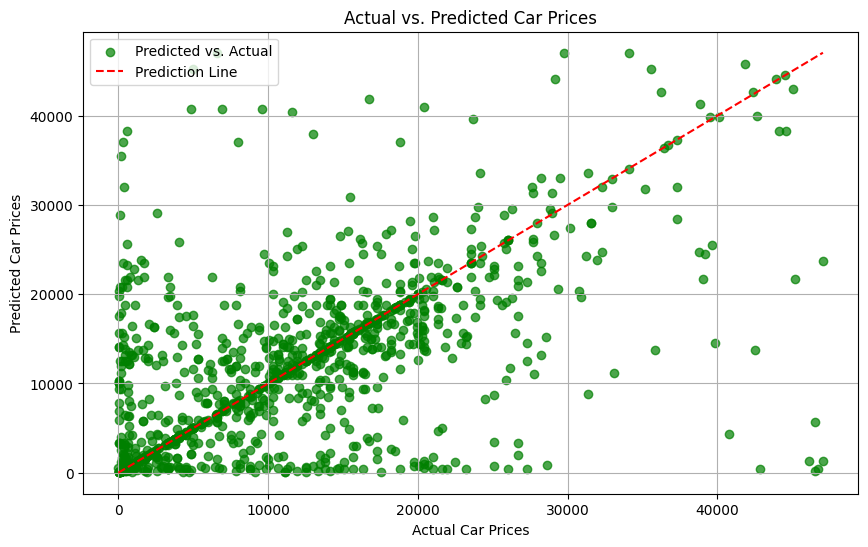

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='green', label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Prediction Line')

plt.xlabel("Actual Car Prices")
plt.ylabel("Predicted Car Prices")
plt.title("Actual vs. Predicted Car Prices")
plt.legend()
plt.grid(True)
plt.show()

### Random Forest Regressor

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf = RandomForestRegressor(random_state=42)
rf.fit(x_train, y_train)
y_train_pred = rf.predict(x_train)
y_test_pred = rf.predict(x_test)
train_rmse_rf = np.sqrt(root_mean_squared_error(y_train, y_train_pred))
test_rmse_rf = np.sqrt(root_mean_squared_error(y_test, y_test_pred))
print(f"Train RMSE: {train_rmse_rf}")
print(f"Test RMSE: {test_rmse_rf}\n")
print("R squared for train is :", rf.score(x_train,y_train))
print("R squared for test is :", rf.score(x_test,y_test))

Train RMSE: 51.557194208124784
Test RMSE: 82.04954763232573

R squared for train is : 0.9197273040289738
R squared for test is : 0.517529420294419


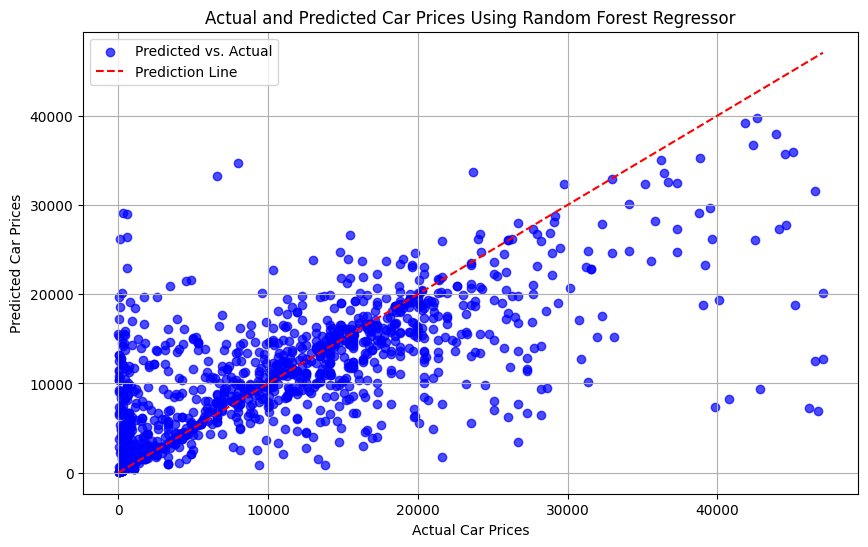

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Prediction Line')

plt.xlabel("Actual Car Prices")
plt.ylabel("Predicted Car Prices")
plt.title("Actual and Predicted Car Prices Using Random Forest Regressor")
plt.legend()
plt.grid(True)
plt.show()

### Decision Tree Regressor

In [29]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(x_train, y_train)
y_train_pred = dt.predict(x_train)
y_test_pred = dt.predict(x_test)
train_rmse_dt = np.sqrt(root_mean_squared_error(y_train, y_train_pred))
test_rmse_dt = np.sqrt(root_mean_squared_error(y_test, y_test_pred))
print(f"Train RMSE: {train_rmse_dt}")
print(f"Test RMSE: {test_rmse_dt}\n")
print("R squared for train is :",dt.score(x_train,y_train))
print("R squared for test is :", dt.score(x_test,y_test))

Train RMSE: 31.76441677137127
Test RMSE: 91.66034027188076

R squared for train is : 0.9884342368805281
R squared for test is : 0.2485641123800011


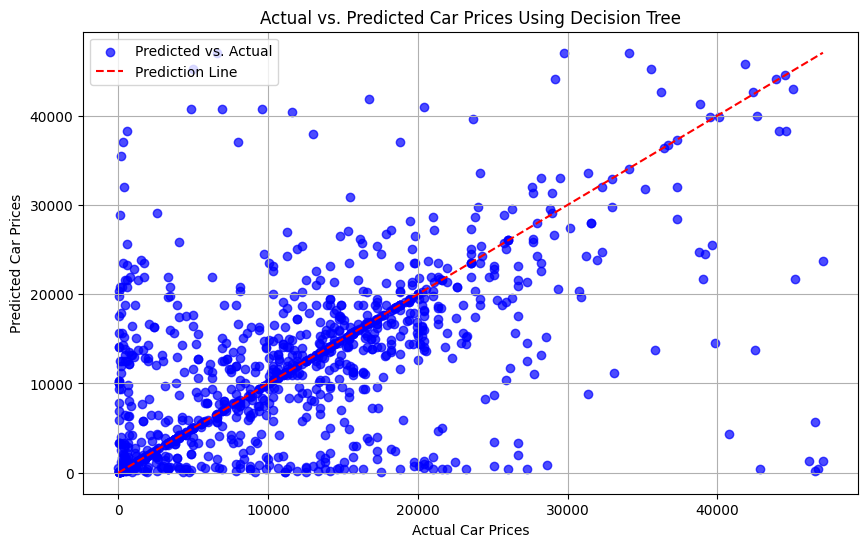

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Prediction Line')

plt.xlabel("Actual Car Prices")
plt.ylabel("Predicted Car Prices")
plt.title("Actual vs. Predicted Car Prices Using Decision Tree")
plt.legend()
plt.grid(True)
plt.show()

### Support Vector Regression (SVR)

In [91]:
from sklearn.svm import SVR
svr = SVR()
svr.fit(x_train, y_train)
y_train_pred = svr.predict(x_train)
y_test_pred = svr.predict(x_test)
train_rmse_svr = np.sqrt(root_mean_squared_error(y_train, y_train_pred))
test_rmse_svr = np.sqrt(root_mean_squared_error(y_test, y_test_pred))
print(f"Train RMSE: {train_rmse_svr}")
print(f"Test RMSE: {test_rmse_svr}\n")
print("R squared for train is :",svr.score(x_train,y_train)*100)
print("R squared for test is :", svr.score(x_test,y_test)*100)


Train RMSE: 95.81785873999911
Test RMSE: 97.04078580426615

R squared for train is : 0.4345168531255772
R squared for test is : 0.3636292633549032


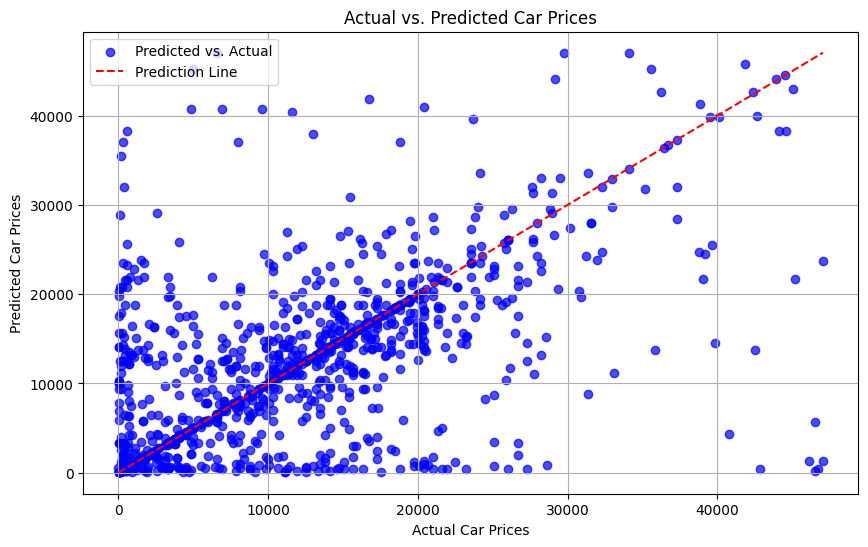

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='blue', label='Predicted vs. Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Prediction Line')

plt.xlabel("Actual Car Prices")
plt.ylabel("Predicted Car Prices")
plt.title("Actual vs. Predicted Car Prices")
plt.legend()
plt.grid(True)
plt.show()

# Results
Basic results for our regression models to predict price for the cleaned_data CSV

| Model | Training Features | RMSE train | R2 train | RMSE test | R2 test |
|:---|:---|:---|:---|:---|:---|
|Linear Regression|Model, Vehicle_Age, Fuel type, Mileage, Category, Price|92.05|0.18|92.55|0.22|
|Random Forest Regressor|Model, Vehicle_Age, Fuel type, Mileage, Category, Price|51.58|0.92|82.05|0.52|
|Decision Tree Regressor|Model, Vehicle_Age, Fuel type, Mileage, Category, Price|31.76|0.99|91.66|0.25|
|Support Vector Regression|Model, Vehicle_Age, Fuel type, Mileage, Category, Price|95.81|0.44|97.04|0.36|

This shows that the best model and the one I am going to be using to predict car prices will be the decision tree regressor because it is balanced and strong. High R² on training (0.99) and test (0.25) indicates it captures relationships well. Test RMSE (91.66) is reasonable, suggesting better generalization. 

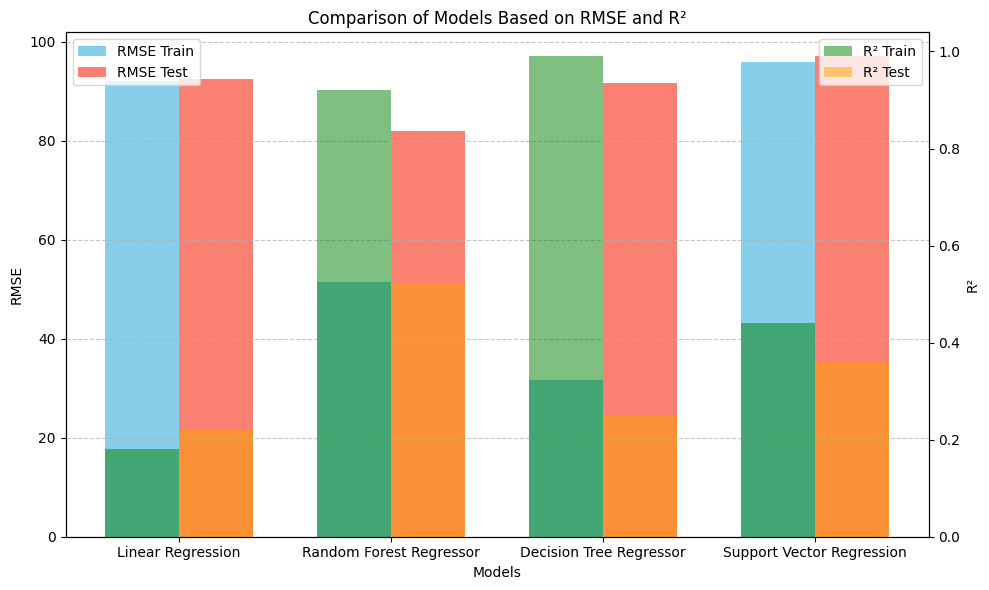

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
models = ['Linear Regression', 'Random Forest Regressor', 'Decision Tree Regressor', 'Support Vector Regression']
rmse_train = [92.049, 51.557, 31.76, 95.81]
rmse_test = [92.55, 82.049, 91.66, 97.04]
r2_train = [0.18, 0.92, 0.99, 0.44]
r2_test = [0.22, 0.52, 0.25, 0.36]

# Set the positions of the bars on the x-axis
x = np.arange(len(models))

# Define the width of the bars
width = 0.35

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot RMSE values (train and test) as bars
bars1 = ax1.bar(x - width / 2, rmse_train, width, label='RMSE Train', color='skyblue')
bars2 = ax1.bar(x + width / 2, rmse_test, width, label='RMSE Test', color='salmon')

# Create a second y-axis for R² values
ax2 = ax1.twinx()

# Plot R² values (train and test) as bars
bars3 = ax2.bar(x - width / 2, r2_train, width, label='R² Train', alpha=0.5, color='green')
bars4 = ax2.bar(x + width / 2, r2_test, width, label='R² Test', alpha=0.5, color='orange')

# Labeling
ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE', color='black')
ax2.set_ylabel('R²', color='black')
ax1.set_title('Comparison of Models Based on RMSE and R²')

# Set x-ticks and labels
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Add grid lines
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


### Predicting Car Prices using Decision Tree Regressor

Below is code that I created for a fake car to see what the predicted price would be.

In [35]:
practice_car_data = {
    "Model": 8000,
    "Vehicle_Age": 10,
    "Fuel type": 11000,
    "Mileage": 45000,
    "Category": 23000
}
pcdf = pd.DataFrame([practice_car_data])

predicted_price = dt.predict(pcdf)
print("Predicted Selling Price:", predicted_price)

Predicted Selling Price: [12544.]


Below is an actual data point from the data set and I will be checkeing to see if it accurate or not. The Car that I am looking at is the Ford Escape that can be found on row 5 of cleaned_data CSV included in the repository. The Price of that car is $3607. The Predicted price using Decision Tree Regressor is $3607 which is the exact price given the exact attributes.

In [36]:
real_car_data = {
    "Model": 8159.228188,
    "Vehicle_Age": 13,
    "Fuel type": 10849.320570,
    "Mileage": 168966,
    "Category": 23684.285949
}
rcdf = pd.DataFrame([real_car_data])

predicted_price = dt.predict(rcdf)
print("Predicted Selling Price:", predicted_price)

Predicted Selling Price: [3607.]


In [37]:
real_car_data2 = {
    "Model": 11430.788550,
    "Vehicle_Age": 14,
    "Fuel type": 10849.320570,
    "Mileage": 258909,
    "Category": 11381.245873
}
rcdf2 = pd.DataFrame([real_car_data2])

predicted_price2 = dt.predict(rcdf2)
print("Predicted Selling Price:", predicted_price2)

Predicted Selling Price: [1803.]


In [58]:
real_car_data3 = {
    "Model": 11430.788550,
    "Vehicle_Age": 9,
    "Fuel type": 10849.320570,
    "Mileage": 258909,
    "Category": 11381.245873
}
rcdf3 = pd.DataFrame([real_car_data3])

predicted_price3 = dt.predict(rcdf3)
print("Predicted Selling Price:", predicted_price3)

Predicted Selling Price: [1803.]


Training set shape: (4952, 5) (4952,)
Testing set shape: (1238, 5) (1238,)


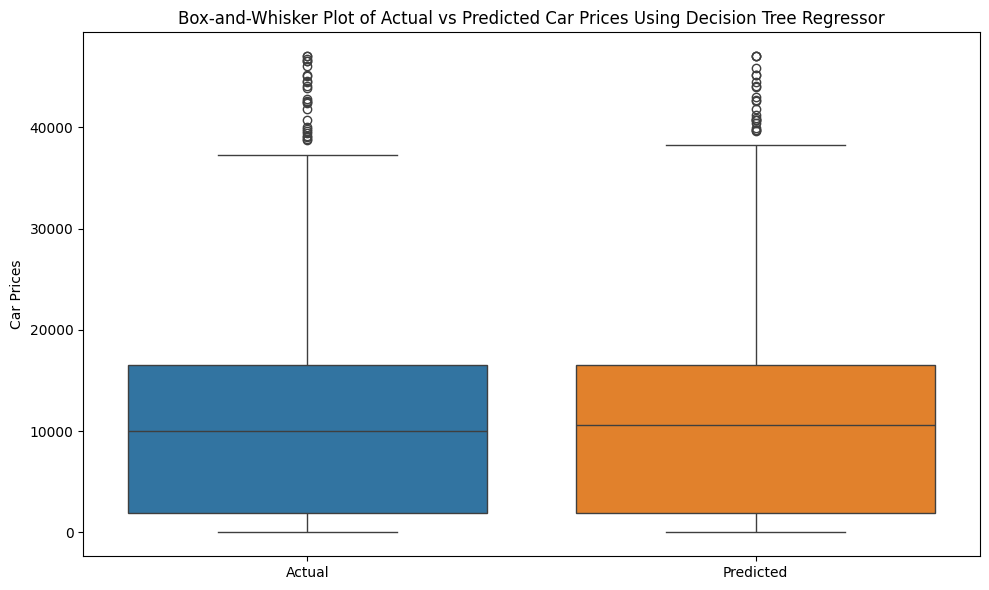

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(ind_var, dep_var , test_size = 0.2, random_state = 123, stratify=None)
print("Training set shape:", x_train.shape, y_train.shape)
print("Testing set shape:", x_test.shape, y_test.shape)

# Assuming 'cleaned_data' is already available and contains 'Price' as the target variable
# Split the data into features (X) and target (y)
# Split into training and testing sets

# Initialize and train the Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(x_train, y_train)

# Make predictions on the test set
y_pred = dt_regressor.predict(x_test)

# Create a DataFrame for easy plotting
import pandas as pd
results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotting box-and-whisker plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=results[['Actual', 'Predicted']], orient='vertical')

# Adding title and labels
plt.title('Box-and-Whisker Plot of Actual vs Predicted Car Prices Using Decision Tree Regressor')
plt.ylabel('Car Prices')
plt.xticks([0, 1], ['Actual', 'Predicted'])

# Display the plot
plt.tight_layout()
plt.show()

In [116]:
cleaned_data.head(5)

,Price,Model,Category,Fuel type,Mileage,Vehicle_Age
3,3607,8159.228188,23684.285949,10849.320570,168966,13
4,11726,11088.957399,11381.245873,17377.351527,91901,10
6,1803,11430.788550,11381.245873,10849.320570,258909,14
7,549,14438.978684,14231.545902,17377.351527,216118,11
16,7683,16081.072668,14231.545902,17377.351527,121840,8
